In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

import time
import copy
import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.transforms as transforms

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
# Giving Colab access to the Drive
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/CAIS++/WinterProj/

Mounted at /content/drive/
/content/drive/My Drive/CAIS++/WinterProj


In [ ]:
x=0
tdir = '/content/drive/My Drive/CAIS++/WinterProj/archive/test/muffin/'
vdir='/content/drive/My Drive/CAIS++/WinterProj/archive/valid/muffin/'

for filename in os.listdir(tdir):
  if x%2==0:
    os.rename(tdir+filename, vdir+filename) # Move half of the images from the test set to create a valid set
  x=x+1

In [ ]:
batch_size = 32

normalize_mean = (166/255, 155/255, 141/255) # Taken from only part of the dataset, since the dataset is too large the code never stopped
normalize_std = (59/255, 58/255, 52/255)

print(normalize_mean)
print(normalize_std)

transform = transforms.Compose(
    [transforms.Resize((224,224)),transforms.ToTensor(),
     transforms.Normalize((0.6509803921568628, 0.6078431372549019, 0.5529411764705883), (0.23137254901960785, 0.22745098039215686, 0.20392156862745098))]) 

# ^ Resizes all images to 224 and 224 and normalizes them to fit in the range 0 to 1

valid_data_dir = r'/content/drive/My Drive/CAIS++/WinterProj/archive/valid/'
train_data_dir = r'/content/drive/My Drive/CAIS++/WinterProj/archive/train/'
test_data_dir = r'/content/drive/My Drive/CAIS++/WinterProj/archive/test/'

train_dataset = datasets.ImageFolder(train_data_dir, transform=transform) # Create datasets from folders
valid_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True) # Load them into dataloaders
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle = True)

data_loaders = {"train":train_loader, "valid":valid_loader}
dataset_sizes = {"train":len(train_dataset), "valid":len(valid_dataset)}

class_names = ['chihuahua','muffin']

test_dataset

Dataset ImageFolder
    Number of datapoints: 592
    Root location: /content/drive/My Drive/CAIS++/WinterProj/archive/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.6509803921568628, 0.6078431372549019, 0.5529411764705883), std=(0.23137254901960785, 0.22745098039215686, 0.20392156862745098))
           )

In [ ]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# load the resnet model

############### YOUR CODE STARTS HERE ###############
model_ft = models.resnet18(pretrained=True)

# find the input size of the FC layers
num_features = model_ft.fc.in_features
# modify the FC layer to output 2, and the input should be...?
model_ft.fc = nn.Linear(num_features, 2)

# save model to device
model_ft = model_ft.to(device)

# define loss for classification
criterion = nn.CrossEntropyLoss() # Binary problem (x) 


# define whatever optimizer you want! (TODO: Fill in ____ and blanks)
optimizer_ft = optim.Adam(model_ft.parameters())
############### YOUR CODE ENDS HERE ###############

# decay your learning rate across epochs-- this helps our model converge better and prevents overshooting a local minima
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Train model definition
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print_frequency = 10
            for index, (inputs, labels) in enumerate(data_loaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # if index % print_frequency == 0:
                #   print(f"{index} loss: {running_loss}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Call the train model function
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1556 Acc: 0.9449
valid Loss: 0.0804 Acc: 0.9687

Epoch 1/9
----------
train Loss: 0.0613 Acc: 0.9784
valid Loss: 0.0445 Acc: 0.9844

Epoch 2/9
----------
train Loss: 0.0727 Acc: 0.9761
valid Loss: 0.1729 Acc: 0.9406

Epoch 3/9
----------
train Loss: 0.0666 Acc: 0.9751
valid Loss: 0.0585 Acc: 0.9768

Epoch 4/9
----------
train Loss: 0.0544 Acc: 0.9820
valid Loss: 0.0949 Acc: 0.9582

Epoch 5/9
----------
train Loss: 0.0321 Acc: 0.9882
valid Loss: 0.0090 Acc: 0.9973

Epoch 6/9
----------
train Loss: 0.0381 Acc: 0.9865
valid Loss: 0.0270 Acc: 0.9915

Epoch 7/9
----------
train Loss: 0.0128 Acc: 0.9958
valid Loss: 0.0037 Acc: 0.9994

Epoch 8/9
----------
train Loss: 0.0055 Acc: 0.9985
valid Loss: 0.0021 Acc: 0.9996

Epoch 9/9
----------
train Loss: 0.0039 Acc: 0.9987
valid Loss: 0.0015 Acc: 0.9996

Training complete in 31m 27s
Best val Acc: 0.999577


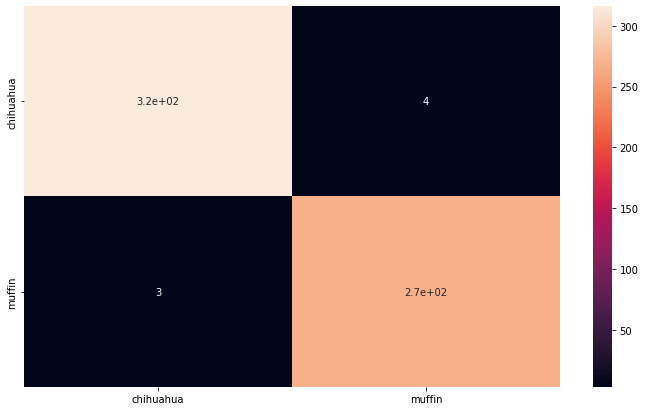

In [ ]:
y_pred = []
y_true = []

mean = (109.25825267789307, 116.46286943178183, 128.88798684144632)
std = (54.269946772031666, 58.04371729089041, 71.18820872545112)

def normal_dist(x, mean, sd):
  prob_density = (np.pi*sd) * np.exp(-.5*((x-mean)/sd)**2)
  return prob_density

# iterate over test data
for inputs, labels in test_loader:
        inputs = inputs.to(device)
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')